In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', index_col='PassengerId')
df.columns = df.columns.str.lower()
df.index.name = 'id'
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
id,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Drop Columns

In [3]:
# list of functions to run in Pipeline
transform_functions = []

In [4]:
def drop_ticket_column(df):
    return df.drop([ 'ticket' ], axis=1)

transform_functions.append(drop_ticket_column)

df = drop_ticket_column(df)

# Missing Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
survived    891 non-null int64
pclass      891 non-null int64
name        891 non-null object
sex         891 non-null object
age         714 non-null float64
sibsp       891 non-null int64
parch       891 non-null int64
fare        891 non-null float64
cabin       204 non-null object
embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


In [6]:
# columns with NA
df.isnull().sum().to_frame()

,0
survived,0
pclass,0
name,0
sex,0
age,177
sibsp,0
parch,0
fare,0
cabin,687
embarked,2


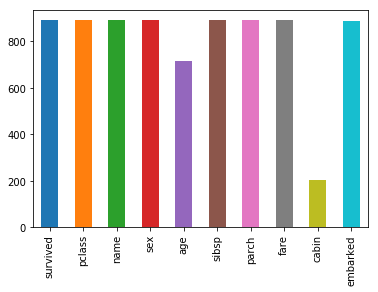

In [7]:
df.notnull().sum().plot(kind='bar')

### Build Title from Name

In [8]:
def replace_name_by_title(df):
    df['title'] = df['name'].str.extract('([A-Za-z]+)\.',expand=True)

    mapping = {'Mlle': 'Miss',
               'Major': 'Mr',
               'Col': 'Mr',
               'Sir': 'Mr',
               'Don': 'Mr',
               'Mme': 'Mrs',
               'Jonkheer': 'Mr',
               'Lady': 'Mrs',
               'Capt': 'Mr',
               'Countess': 'Mrs',
               'Ms': 'Miss',
               'Dona': 'Mrs'}

    df.replace({'title': mapping}, inplace=True)
#     df.drop('name', axis=1, inplace=True)
    return df

transform_functions.append(replace_name_by_title)

df = replace_name_by_title(df)

### Missing Age

### Use Class and Titles to fix Age

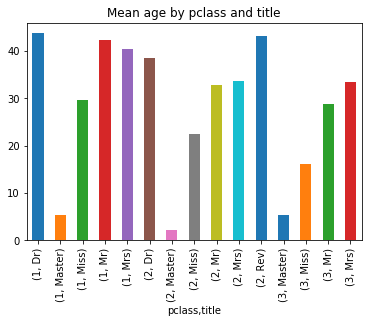

In [9]:
mean_ages_by_pclass_and_title = df.groupby(['pclass', 'title'])['age'].mean()
mean_ages_by_pclass_and_title.plot(kind='bar', title='Mean age by pclass and title')

In [10]:
def impute_age_row_by_pclass_title(row):
    if np.isnan(row['age']):
        return mean_ages_by_pclass_and_title.loc[row['pclass'], row['title']]
    else:
        return row['age']
    
def impute_age(df):
    df['age'] = df.apply(impute_age_row_by_pclass_title, axis=1)
    return df

transform_functions.append(impute_age)

df = impute_age(df)

### Missing Fare (on Test set)

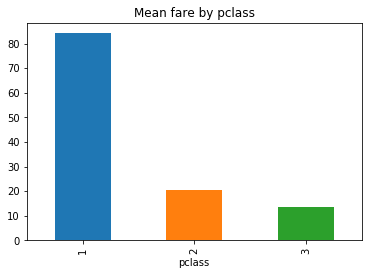

In [11]:
mean_fare_by_pclass = df.groupby('pclass')['fare'].mean()
mean_fare_by_pclass.plot(kind='bar', title='Mean fare by pclass')

Impute fare by mean within pclass

In [12]:
# df['fare'] = df.groupby("pclass")['fare'].transform(lambda x: x.fillna(x.mean()))

In [13]:
def impute_fare_on_row(row):
    if np.isnan(row['fare']):
        return mean_fare_by_pclass[row['pclass']]
    else:
        return row['fare']

def impute_fare(df):
    df['fare'] = df.apply(impute_fare_on_row, axis=1)
    return df

impute_fare(df)

transform_functions.append(impute_fare)

### Transform Sex

In [14]:
def categorize_sex(df):
    df['female'] = ((df['sex'] == 'female') * 1)
    df.drop('sex', axis=1, inplace=True)
    return df

categorize_sex(df)

transform_functions.append(categorize_sex)

In [15]:
df.head()

,survived,pclass,name,age,sibsp,parch,fare,cabin,embarked,title,female
id,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,NaN,S,Mr,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C85,C,Mrs,1
3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,NaN,S,Miss,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,C123,S,Mrs,1
5,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,NaN,S,Mr,0


## Feature Engineering

### Family Size

In [16]:
def build_family_size(df):
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    return df

df = build_family_size(df)

transform_functions.append(build_family_size)

Text(0.5,0,'Family Size')

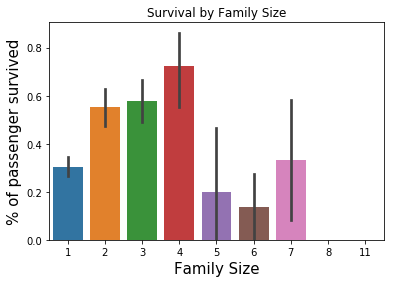

In [17]:
sns.barplot(x = "family_size", y = "survived", data=df)
plt.title("Survival by Family Size")
plt.ylabel("% of passenger survived", fontsize = 15)
plt.xlabel("Family Size",fontsize = 15)

In [18]:
def group_family_size(v):
    if v==1:
        return 'alone'
    elif v <= 3:
        return 'small'
    elif v == 4:
        return 'medium'
    else:
        return 'large'

def build_family_size_group(df):
    df['family_size_group'] = df['family_size'].apply(group_family_size)
    return df

df = build_family_size_group(df)

transform_functions.append(build_family_size_group)

Text(0.5,0,'Family Size group')

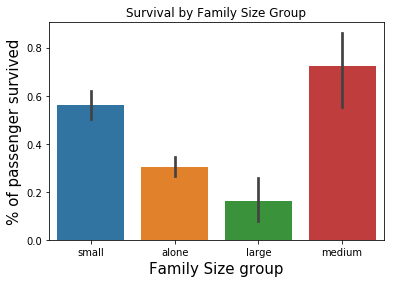

In [19]:
sns.barplot(x = "family_size_group", y = "survived", data=df)
plt.title("Survival by Family Size Group")
plt.ylabel("% of passenger survived", fontsize = 15)
plt.xlabel("Family Size group",fontsize = 15)

### Fare banding

In [20]:
def group_fares(fare):
    if fare == 0:
        return '0'
    elif fare <= 10:
        return '0_10'
    elif fare <= 30:
        return '10_30'
    else:
        return '30+'
    

def build_fare_group(df):
    df['fare_group'] = df['fare'].apply(group_fares)
    return df

df = build_fare_group(df)
transform_functions.append(build_fare_group)

Text(0.5,0,'Fare group')

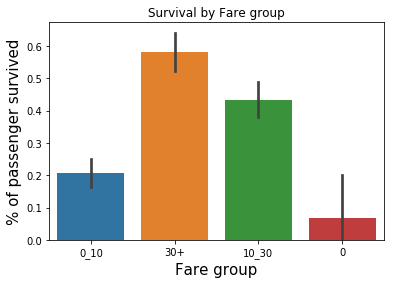

In [21]:
sns.barplot(x = "fare_group", y = "survived", data=df)
plt.title("Survival by Fare group")
plt.ylabel("% of passenger survived", fontsize = 15)
plt.xlabel("Fare group",fontsize = 15)

# EDA

In [22]:
df.describe()

,survived,pclass,age,sibsp,parch,fare,female,family_size
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.439039,0.523008,0.381594,32.204208,0.352413,1.904602
std,0.486592,0.836071,13.557659,1.102743,0.806057,49.693429,0.477990,1.613459
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.910400,0.000000,1.000000
50%,0.000000,3.000000,28.724891,0.000000,0.000000,14.454200,0.000000,1.000000
75%,1.000000,3.000000,36.750000,1.000000,0.000000,31.000000,1.000000,2.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,11.000000


In [23]:
df.groupby('survived').mean()

,pclass,age,sibsp,parch,fare,female,family_size
survived,,,,,,,
0,2.531876,30.265368,0.553734,0.329690,22.117887,0.147541,1.883424
1,1.950292,28.112564,0.473684,0.464912,48.395408,0.681287,1.938596


Text(0.5,1,'Correlations Among Features')

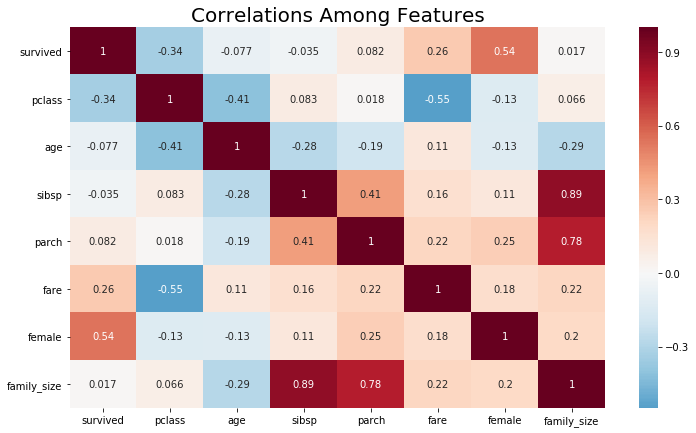

In [24]:
plt.subplots(figsize = (12,7))
sns.heatmap(df.corr(), annot=True, cmap="RdBu_r", center=0)
plt.title("Correlations Among Features", fontsize = 20)

In [25]:
df.columns

Index(['survived', 'pclass', 'name', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title', 'female', 'family_size', 'family_size_group',
       'fare_group'],
      dtype='object')

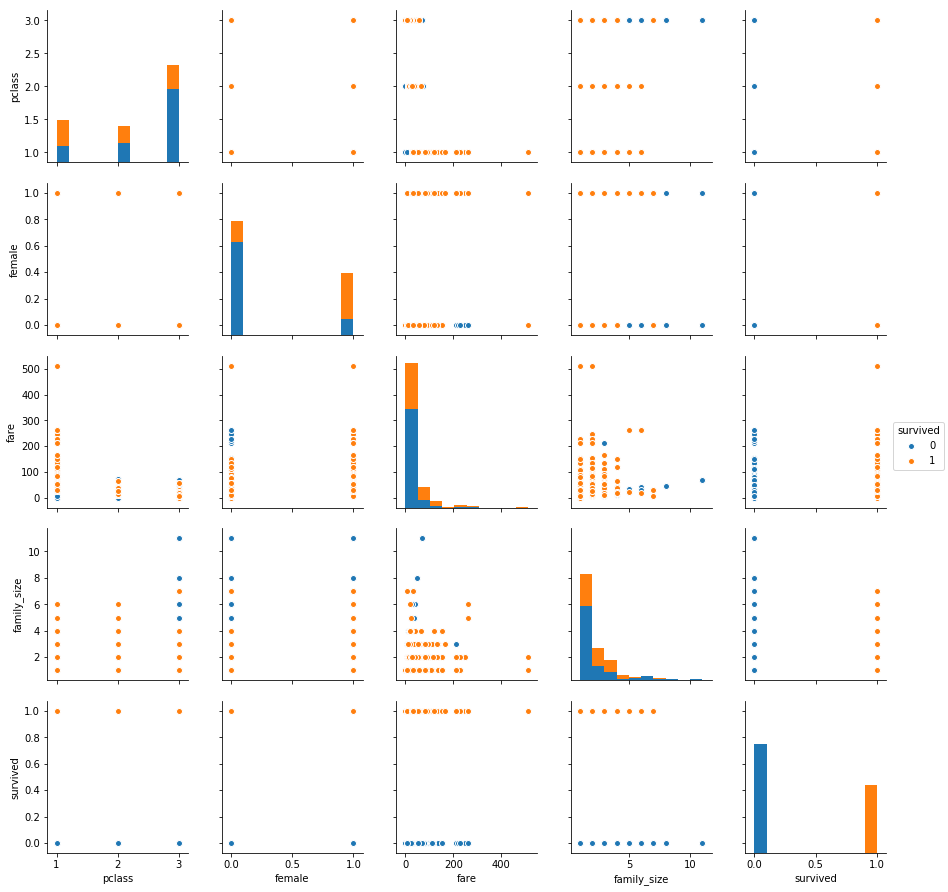

In [26]:
sns.pairplot(df[['pclass', 'female', 'fare', 'family_size', 'survived']], hue='survived')

## Survival by Gender

([<matplotlib.axis.XTick at 0x1a193e5d30>,
 <a list of 2 Text xticklabel objects>)

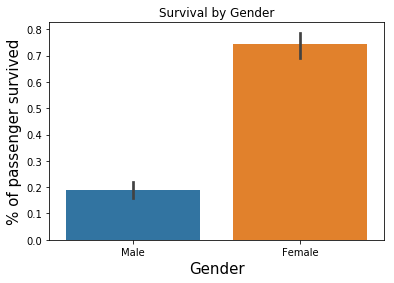

In [27]:
sns.barplot(x = "female", y = "survived", data=df)
plt.title("Survival by Gender")
labels = ['Male', 'Female']
plt.ylabel("% of passenger survived", fontsize = 15)
plt.xlabel("Gender",fontsize = 15)
plt.xticks(sorted(df.female.unique()), labels)

## Survival by Class

Text(0.5,0,'Class')

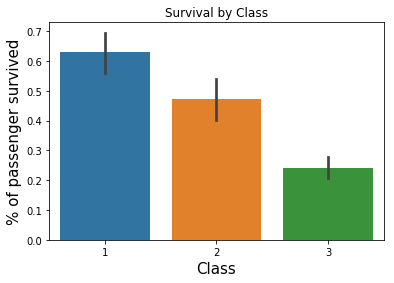

In [28]:
sns.barplot(x = "pclass", y = "survived", data=df)
plt.title("Survival by Class")
plt.ylabel("% of passenger survived", fontsize = 15)
plt.xlabel("Class",fontsize = 15)

### Survival by Fare

Text(0.5,1,'Survival by Fare')

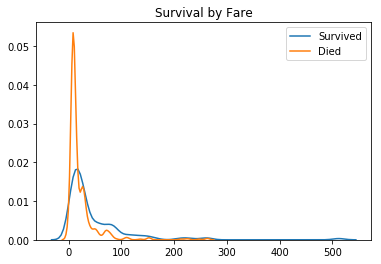

In [29]:
sns.kdeplot(df[df['survived']==1]["fare"], label="Survived")
sns.kdeplot(df[df['survived']==0]["fare"], label="Died")

plt.title("Survival by Fare")

## Survival by Age

Text(0.5,1,'Survival by Age (imputed)')

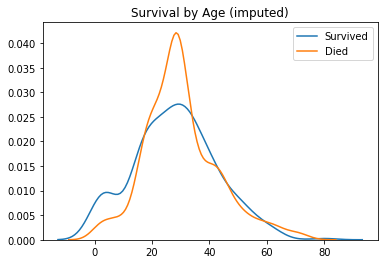

In [30]:
sns.kdeplot(df[df['survived']==1]["age"], label="Survived")
sns.kdeplot(df[df['survived']==0]["age"], label="Died")

plt.title("Survival by Age (imputed)")

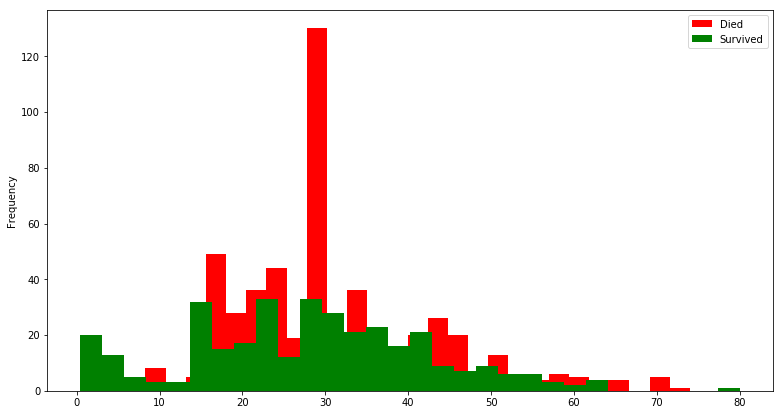

In [31]:
plt.figure(figsize=(13,7))
df[df['survived']==0]['age'].plot(bins=30, kind='hist', label='Died', color='red') 
df[df['survived']==1]['age'].plot(bins=30, kind='hist', label='Survived', color='green') 
plt.legend()

## Dummies

In [32]:
df.columns

Index(['survived', 'pclass', 'name', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title', 'female', 'family_size', 'family_size_group',
       'fare_group'],
      dtype='object')

In [33]:
def build_dummies(df):
    return pd.get_dummies(df, columns=['family_size_group']) #, 'fare_group', 'pclass', 'title'])

df = build_dummies(df)
transform_functions.append(build_dummies)

### Select Features

In [34]:
df.columns

Index(['survived', 'pclass', 'name', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked', 'title', 'female', 'family_size', 'fare_group',
       'family_size_group_alone', 'family_size_group_large',
       'family_size_group_medium', 'family_size_group_small'],
      dtype='object')

In [35]:
# X = df[[ 'female', 'pclass', 'fare', 'sibsp', 'parch' ]]

features = [ 'female','pclass', 'age', 'fare',
             'family_size_group_alone', 'family_size_group_large', 'family_size_group_medium', 'family_size_group_small']
target = 'survived' 
cols = features + [ target ]

final_df = df[cols]
X = df[features]
y = df[target]

## Classifiers Evaluation

In [36]:
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import train_test_split

def classifier_accuracy(classifier, X, y):
    accuracies = []
    
    for train_index, test_index in RepeatedKFold(n_splits=5, n_repeats=5).split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = classifier.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracies.append((y_pred == y_test).sum() / len(y_test))

    return np.mean(accuracies)

In [37]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = [ LogisticRegression(),
                SVC(),
                GradientBoostingClassifier(),
                DecisionTreeClassifier(),
                RandomForestClassifier() ]

for classifier in classifiers:
    start_time = time.time()
    accuracy = classifier_accuracy(classifier, X, y)
    end_time = time.time()
    
    duration = end_time - start_time
    print("{}%  {}s  {}".format(round(accuracy*100,1), round(duration,2), type(classifier).__name__))

81.3%  0.08s  LogisticRegression
69.6%  0.41s  SVC
83.1%  1.38s  GradientBoostingClassifier
77.9%  0.07s  DecisionTreeClassifier
80.4%  0.35s  RandomForestClassifier


## Tune GradientBoosting

In [38]:
from sklearn.model_selection import GridSearchCV 
from sklearn import cross_validation, metrics

/Users/rgabillet/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [55]:
# Step 3: determine optimal parameters for Gradient Boosting

param_test3 = {'max_depth':range(2,14,2),
               'n_estimators':range(50, 200, 25),
               'min_samples_split':range(50, 250, 50)}

gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
                        param_grid = param_test3,
                        scoring='accuracy',
                        n_jobs=4,
                        iid=False,
                        cv=4)

gsearch3.fit(final_df[features],df[target])

#gsearch3.grid_scores_
final_model = gsearch3
gsearch3.best_params_, gsearch3.best_score_

({'max_depth': 10, 'min_samples_split': 200, 'n_estimators': 175},
 0.8417648961020597)

# Submission

In [56]:
!head test.csv

In [57]:
test_df = pd.read_csv('test.csv', index_col='PassengerId')
test_df.columns = test_df.columns.str.lower()
test_df.index.name = 'id'
test_df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
id,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Transform

In [58]:
for f in transform_functions:
    test_df = f(test_df)
    
test_df.head(10)

,pclass,name,age,sibsp,parch,fare,cabin,embarked,title,female,family_size,fare_group,family_size_group_alone,family_size_group_large,family_size_group_medium,family_size_group_small
id,,,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",34.5,0,0,7.8292,NaN,Q,Mr,0,1,0_10,1,0,0,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,7.0000,NaN,S,Mrs,1,2,0_10,0,0,0,1
894,2,"Myles, Mr. Thomas Francis",62.0,0,0,9.6875,NaN,Q,Mr,0,1,0_10,1,0,0,0
895,3,"Wirz, Mr. Albert",27.0,0,0,8.6625,NaN,S,Mr,0,1,0_10,1,0,0,0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,12.2875,NaN,S,Mrs,1,3,10_30,0,0,0,1
897,3,"Svensson, Mr. Johan Cervin",14.0,0,0,9.2250,NaN,S,Mr,0,1,0_10,1,0,0,0
898,3,"Connolly, Miss. Kate",30.0,0,0,7.6292,NaN,Q,Miss,1,1,0_10,1,0,0,0
899,2,"Caldwell, Mr. Albert Francis",26.0,1,1,29.0000,NaN,S,Mr,0,3,10_30,0,0,0,1
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.0,0,0,7.2292,NaN,C,Mrs,1,1,0_10,1,0,0,0


#### Select Features

In [59]:
X_test = test_df[features]
X_test.head()

,female,pclass,age,fare,family_size_group_alone,family_size_group_large,family_size_group_medium,family_size_group_small
id,,,,,,,,
892,0,3,34.5,7.8292,1,0,0,0
893,1,3,47.0,7.0000,0,0,0,1
894,0,2,62.0,9.6875,1,0,0,0
895,0,3,27.0,8.6625,1,0,0,0
896,1,3,22.0,12.2875,0,0,0,1


In [60]:
y_pred = final_model.predict(X_test)

In [61]:
!head gender_submission.csv

In [62]:
submission_df = pd.DataFrame({ 'PassengerId': X_test.index, 'Survived': y_pred }).set_index('PassengerId')
submission_df.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [63]:
submission_df.to_csv('remi_submission_v5.csv')

In [64]:
# !kaggle competitions submit -c titanic -f remi_submission_v5.csv -m "family size band instead of numeric. 0.9091"

In [65]:
submission_df['Survived'].value_counts()

0    264
1    154
Name: Survived, dtype: int64